# General libraries

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import calibration, greedyDecomposition

# Load data

## Time

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
print(PATH)
print(MODELS)

/Users/javigamero/MyMac/DS_Master/TFM
/Users/javigamero/MyMac/DS_Master/TFM/scripts/python/models


In [3]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t.set_index(0, inplace=True)

In [4]:
t0 = 150 # (ns), moment to start considering the slow component, EXPERIMENTAL
t_idx = np.where(t>t0)[1] 

t = np.array(t[t_idx]).reshape(-1).astype(np.int32)
t.shape

(985,)

## Ideal signals

In [5]:
signals_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
signals = pd.read_csv(signals_path, sep=';', header=None)
signals.set_index(0, inplace=True)

signals = signals.iloc[:,t_idx]
signals.shape

(9325, 985)

## Deposited Energy

In [6]:
dE_path = os.path.join(PATH, 'data_preproc/dE.csv')
dE = pd.read_csv(dE_path, sep=';', header=0, index_col=0)

# dE=dE.loc[signals.index, :]

In [7]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False,
                figsize=(5,5)): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v), figsize=figsize)
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure(figsize=figsize)
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return

# Processing signals

## Filtering data by electron peak

It is important to notice some series have a very low electron signal, what 
means that they cannot be extracted from the total one.  
With this in mind, we will use the greedy decomposition to extract the electron 
signal from and take only those signals whose electron is power enough to be 
extractable.

The next figure is an example where the electron could be extractable:

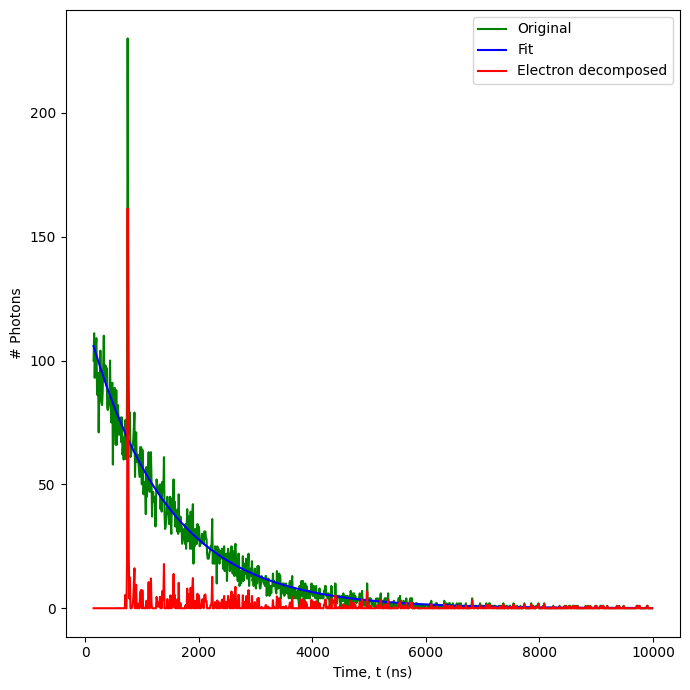

In [8]:
x = signals.iloc[8,:]
model = greedyDecomposition(t, x)
model.automaticFit()
model.extractElectronSignal()
model.plotSignals()

Meanwhile, in the next figure we see an electron without enough intensity. We 
would remove it from the study.

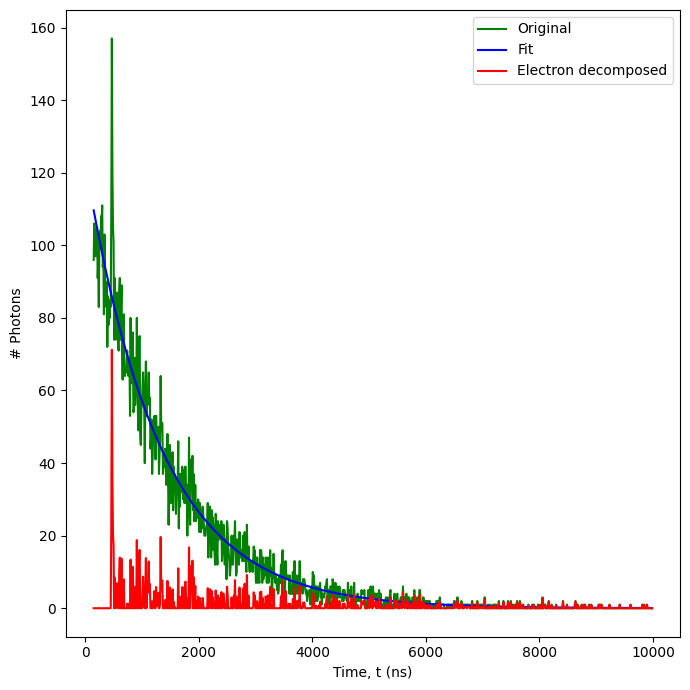

In [9]:
x = signals.iloc[25,:]
model = greedyDecomposition(t, x)
model.automaticFit()
model.extractElectronSignal()
model.plotSignals()

We set a `min_peak` of at least `50` photons of the extracted electron to let the 
serie continue:

In [10]:
m0 = time()

signals_idx = []
min_peak=50
min_t = 500
for idx in signals.index:
    x = signals.loc[idx, :]
    
    model = greedyDecomposition(t, x)
    model.automaticFit()
    model.extractElectronSignal()
    
    x_e = np.array(model.decomp_signal).reshape(-1)
    maxarg = np.argmax(x_e)
    if (x_e[maxarg] > min_peak) and (t[maxarg] > min_t):
        signals_idx.append(idx)
        
signals = signals.loc[signals_idx,:]
print('Time spent filtering: ', time()-m0, '(s)')

Time spent filtering:  3.0911459922790527 (s)


In [11]:
signals.shape

(5252, 985)

In [12]:
dE = dE.loc[signals.index,:]
dE.shape

(5252, 1)

# Decomposing signals

## Load model to decompose signal

In [13]:
from keras.saving import load_model
model = load_model(os.path.join(MODELS, '3layers_Bidir_LSTM_Complex.keras'))

## Predict with the model

In [14]:
y_pred = model.predict(signals)

165/165 [==============================] - 44s 261ms/step


In [15]:
y_pred.shape

(5252, 985, 1)

Example of a good prediction

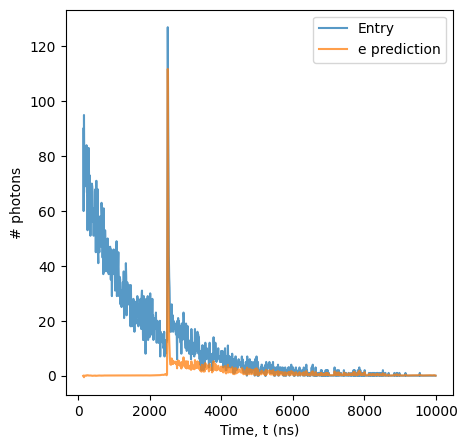

In [16]:
i = 3
v = [signals.iloc[i,:], y_pred[i,:]]
labels = ['Entry', 'e prediction']
plotSignals(t, v, labels, figsize=(5,5))

Example of a bad prediction

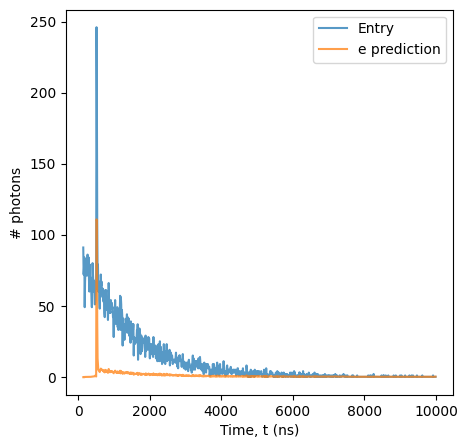

In [17]:
i = 16
v = [signals.iloc[i,:], y_pred[i,:]]
labels = ['Entry', 'e prediction']
plotSignals(t, v, labels, figsize=(5,5))

# Calibration

In [18]:
cal = calibration(y_pred[:,:,0], t-5, multiple=True)
list_integrate = cal._integrateSignal()

In [19]:
np.array(dE.values).reshape(-1).shape


(5252,)

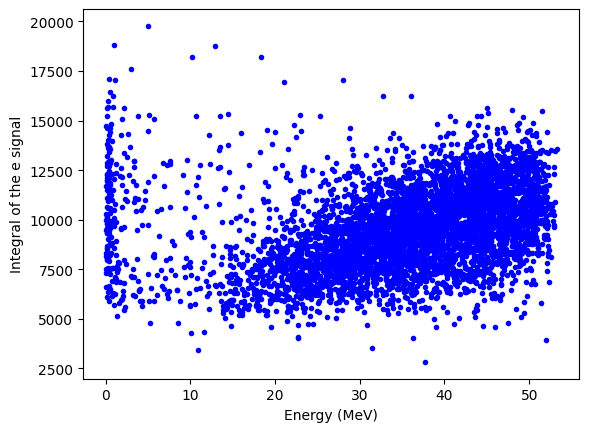

In [23]:
x = np.array(dE.values).reshape(-1)
y = np.array(list_integrate).reshape(-1)

idx = np.where(x>0)
x = x[idx]
y = y[idx]

plt.figure()
plt.plot(x, y, '.b')
plt.xlabel('Energy (MeV)')
plt.ylabel('Integral of the e signal')
plt.show()